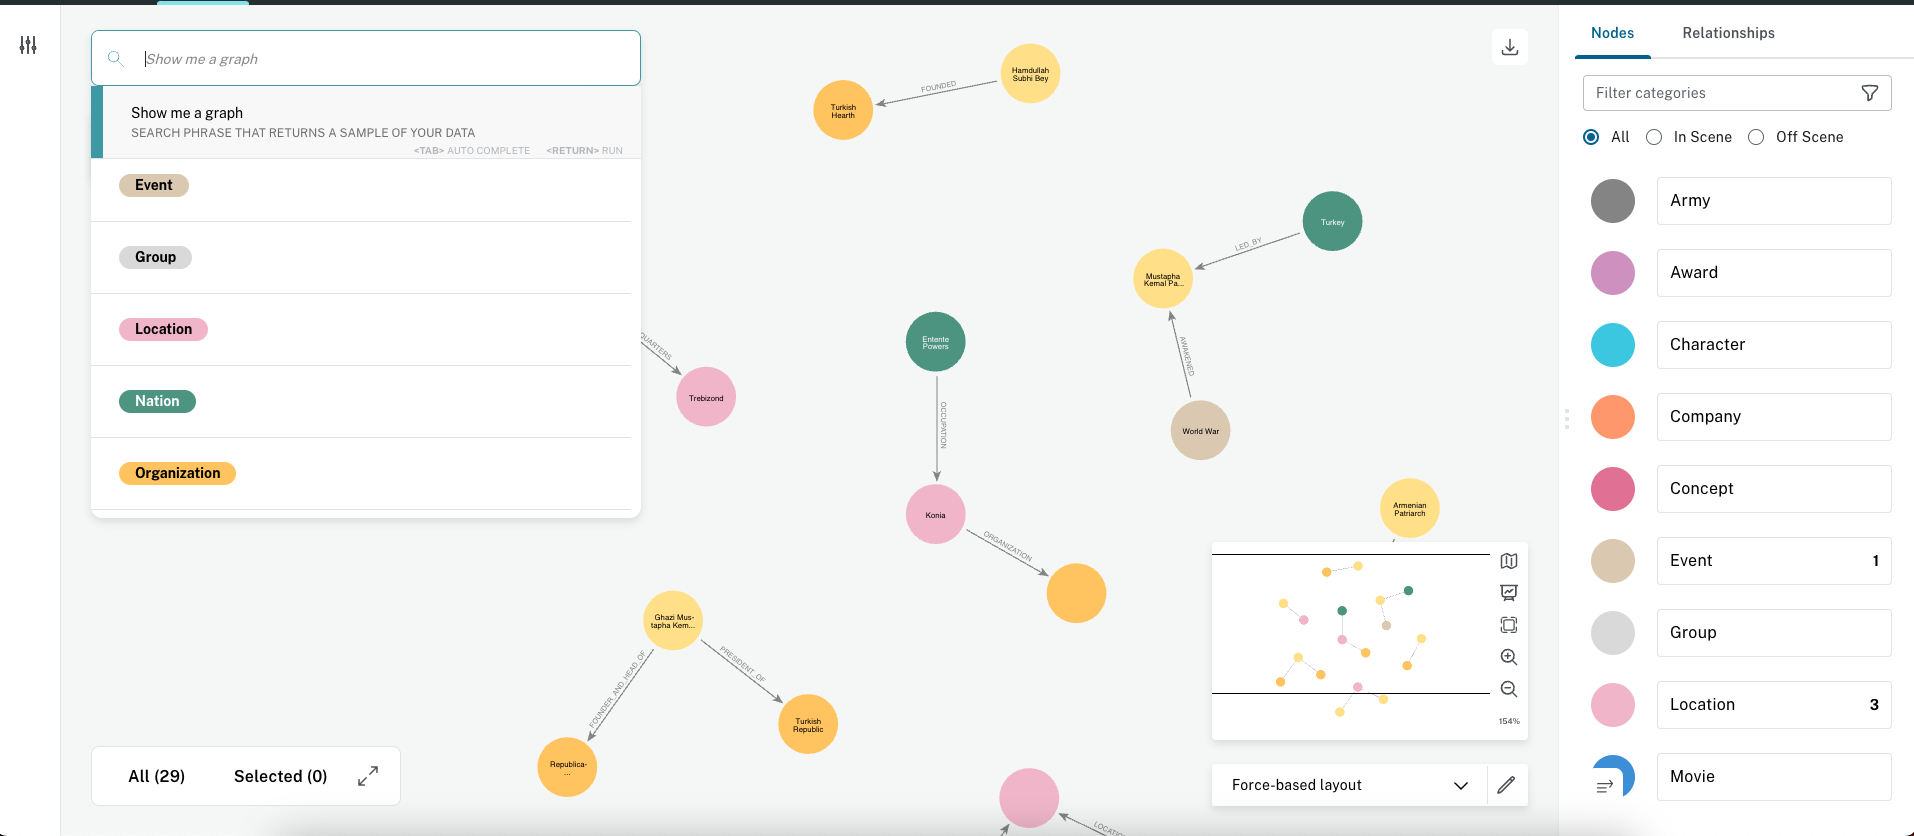

# Constructing knowledge graphs from text using OpenAI functions

Building knowledge graphs from unstructured text is an issue of great interest that receives little research. In my most recent blog article, I describe how I built a knowledge network in Neo4j using the LangChain framework and OpenAI functions. Along with learning all the subtleties of employing LLMs to build a knowledge graph, you will also learn the necessary procedures to develop a production information extraction pipeline.

I would like to thank **Tomaz Bratanic** for preparing this article. You can find the original blog post here. In this article, I worked directly on a book. Those who want to work on Wikipedia can use the code on Tomaz's blog.

LINK:
https://blog.langchain.dev/constructing-knowledge-graphs-from-text-using-openai-functions/



Extracting structured information from unstructured data like text has been around for some time and is nothing new. However, LLMs brought a significant shift to the field of information extraction. If before you needed a team of machine learning experts to curate datasets and train custom models, you only need access to an LLM nowadays. The barrier to entry has dropped significantly, making what was just a couple of years ago reserved for domain experts more accessible to even non-technical people.

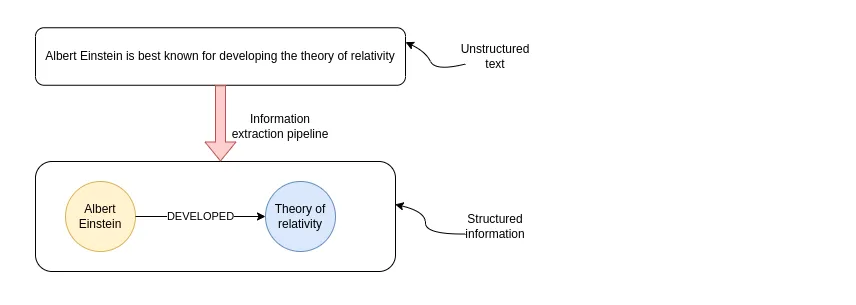

The goal of information extraction pipeline is to extract structured information from unstructured text. Image by **Tomaz Bratanic**.

The image depicts the transformation of unstructured text into structured information. This process, labeled as the information extraction pipeline, results in a graph representation of information. The nodes represent key entities, while the connecting lines denote the relationships between these entities. Knowledge graphs are useful for multi-hop question-answering, real-time analytics, or when you want to combine structured and unstructured data in a single database.

While extracting structured information from text has been made more accessible due to LLMs, it is by no means a solved problem. In this blog post, we will use OpenAI functions in combination with LangChain to construct a knowledge graph from Nutuk book written by M. K. Ataturk. Along the way, we will discuss best practices as well as some limitations of current LLMs.

# Neo4j Environment setup

You need to setup a Neo4j to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also setup a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

The following code will instantiate a LangChain wrapper to connect to Neo4j Database.

In [ ]:

from langchain.graphs import Neo4jGraph

url = "neo4j+s://databases.neo4j.io"
username ="neo4j"
password = ""
graph = Neo4jGraph(
    url=url,
    username=username,
    password=password
)
     

## Information extraction pipeline
A typical information extraction pipeline contains the following steps.

In [ ]:
A typical information extraction pipeline contains the following steps.

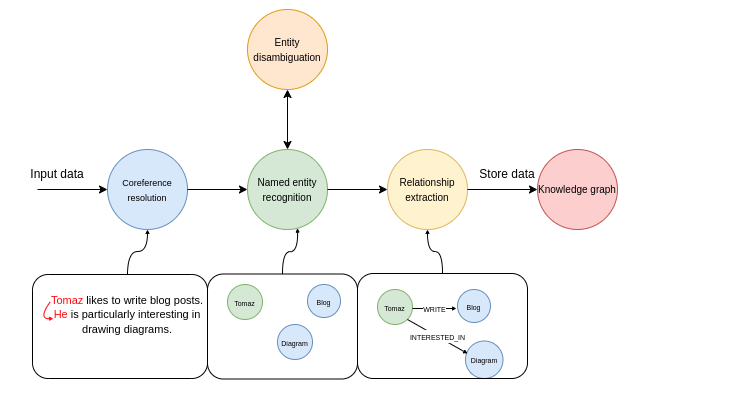

Multiple steps of information extraction pipeline. Image by **Tomaz Bratanic.**

In the first step, we run the input text through a coreference resolution model. The coreference resolution is the task of finding all expressions that refer to a specific entity. Simply put, it links all the pronouns to the referred entity. In the named entity recognition part of the pipeline, we try to extract all the mentioned entities. The above example contains three entities: Tomaz, Blog, and Diagram. The next step is the entity disambiguation step, an essential but often overlooked part of an information extraction pipeline. Entity disambiguation is the process of accurately identifying and distinguishing between entities with similar names or references to ensure the correct entity is recognized in a given context. In the last step, the model tried to identify various relationships between entities. For example, it could locate the LIKES relationship between Tomaz and Blog entities.

# Extracting structured information with OpenAI functions
OpenAI functions are a great fit to extract structured information from natural language. The idea behind OpenAI functions is to have an LLM output a predefined JSON object with populated values. The predefined JSON object can be used as input to other functions in so-called RAG applications, or it can be used to extract predefined structured information from text.

In LangChain, you can pass a Pydantic class as description of the desired JSON object of the OpenAI functions feature. Therefore, we will start by defining the desired structure of information we want to extract from text. LangChain already has definitions of nodes and relationship as Pydantic classes that we can reuse.

Unfortunately, it turns out that OpenAI functions don't currently support a dictionary object as a value. Therefore, we have to overwrite the properties definition to adhere to the limitations of the functions' endpoint.

In [1]:
from langchain.graphs.graph_document import (
    Node as BaseNode,
    Relationship as BaseRelationship,
    GraphDocument,
)
from langchain.schema import Document
from typing import List, Dict, Any, Optional
from langchain.pydantic_v1 import Field, BaseModel

class Property(BaseModel):
  """A single property consisting of key and value"""
  key: str = Field(..., description="key")
  value: str = Field(..., description="value")

class Node(BaseNode):
    properties: Optional[List[Property]] = Field(
        None, description="List of node properties")

class Relationship(BaseRelationship):
    properties: Optional[List[Property]] = Field(
        None, description="List of relationship properties"
    )

class KnowledgeGraph(BaseModel):
    """Generate a knowledge graph with entities and relationships."""
    nodes: List[Node] = Field(
        ..., description="List of nodes in the knowledge graph")
    rels: List[Relationship] = Field(
        ..., description="List of relationships in the knowledge graph"
    )

ModuleNotFoundError: No module named 'langchain'

Here, we have overwritten the properties value to be a list of Property classes instead of a dictionary to overcome the limitations of the API. Because you can only pass a single object to the API, we can to combine the nodes and relationships in a single class called KnowledgeGraph.

In [2]:
def format_property_key(s: str) -> str:
    words = s.split()
    if not words:
        return s
    first_word = words[0].lower()
    capitalized_words = [word.capitalize() for word in words[1:]]
    return "".join([first_word] + capitalized_words)

def props_to_dict(props) -> dict:
    """Convert properties to a dictionary."""
    properties = {}
    if not props:
      return properties
    for p in props:
        properties[format_property_key(p.key)] = p.value
    return properties

def map_to_base_node(node: Node) -> BaseNode:
    """Map the KnowledgeGraph Node to the base Node."""
    properties = props_to_dict(node.properties) if node.properties else {}
    # Add name property for better Cypher statement generation
    properties["name"] = node.id.title()
    return BaseNode(
        id=node.id.title(), type=node.type.capitalize(), properties=properties
    )


def map_to_base_relationship(rel: Relationship) -> BaseRelationship:
    """Map the KnowledgeGraph Relationship to the base Relationship."""
    source = map_to_base_node(rel.source)
    target = map_to_base_node(rel.target)
    properties = props_to_dict(rel.properties) if rel.properties else {}
    return BaseRelationship(
        source=source, target=target, type=rel.type, properties=properties
    )

NameError: name 'Node' is not defined

The only thing left is to do a bit of prompt engineering and we are good to go. How I usually go about prompt engineering is the following:

* Iterate over prompt and improve results using natural language
* If something doesn't work as intended, ask ChatGPT to make it clearer for an LLM to understand the task
* Finally, when the prompt has all the instructions needed, ask ChatGPT to summarize the instructions in a markdown format, saving on tokens and perhaps having more clear instructions

I specifically chose the markdown format as I have seen somewhere that OpenAI models respond better to markdown syntax in prompts, and it seems to be at least plausible from my experience. Iterating over prompt engineering, I came up with the following system prompt for an information extraction pipeline.

In [ ]:
import os
from langchain.chains.openai_functions import (
    create_openai_fn_chain,
    create_structured_output_chain,
)
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
llm = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0)

def get_extraction_chain(
    allowed_nodes: Optional[List[str]] = None,
    allowed_rels: Optional[List[str]] = None
    ):
    prompt = ChatPromptTemplate.from_messages(
        [(
          "system",
          f"""# Knowledge Graph Instructions for GPT-4
## 1. Overview
You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.
- **Nodes** represent entities and concepts. They're akin to Wikipedia nodes.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.
## 2. Labeling Nodes
- **Consistency**: Ensure you use basic or elementary types for node labels.
  - For example, when you identify an entity representing a person, always label it as **"person"**. Avoid using more specific terms like "mathematician" or "scientist".
- **Node IDs**: Never utilize integers as node IDs. Node IDs should be names or human-readable identifiers found in the text.
{'- **Allowed Node Labels:**' + ", ".join(allowed_nodes) if allowed_nodes else ""}
{'- **Allowed Relationship Types**:' + ", ".join(allowed_rels) if allowed_rels else ""}
## 3. Handling Numerical Data and Dates
- Numerical data, like age or other related information, should be incorporated as attributes or properties of the respective nodes.
- **No Separate Nodes for Dates/Numbers**: Do not create separate nodes for dates or numerical values. Always attach them as attributes or properties of nodes.
- **Property Format**: Properties must be in a key-value format.
- **Quotation Marks**: Never use escaped single or double quotes within property values.
- **Naming Convention**: Use camelCase for property keys, e.g., `birthDate`.
## 4. Coreference Resolution
- **Maintain Entity Consistency**: When extracting entities, it's vital to ensure consistency.
If an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"),
always use the most complete identifier for that entity throughout the knowledge graph. In this example, use "John Doe" as the entity ID.
Remember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.
## 5. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination.
          """),
            ("human", "Use the given format to extract information from the following input: {input}"),
            ("human", "Tip: Make sure to answer in the correct format"),
        ])
    return create_structured_output_chain(KnowledgeGraph, llm, prompt, verbose=False)
     

You can see that we are using the 16k version of the GPT-3.5 model. The main reason is that the OpenAI function output is a structured JSON object, and structured JSON syntax adds a lot of token overhead to the result. Essentially, you are paying for the convenience of structured output in increased token space.

Besides the general instructions, I have also added the option to limit which node or relationship types should be extracted from text. You'll see through examples why this might come in handy. We have the Neo4j connection and LLM prompt ready, which means we can define the information extraction pipeline as a single function.

The function takes in a LangChain document as well as optional nodes and relationship parameters, which are used to limit the types of objects we want the LLM to identify and extract. A month or so ago, we added the add_graph_documents method the Neo4j graph object, which we can utilize here to seamlessly import the graph.

In [ ]:
from typing import List, Optional
from tqdm import tqdm

class Document:
    def __init__(self, content: str):
        self.page_content = content

    def to_dict(self):
        return {
            "page_content": self.page_content
        }

def extract_and_store_graph(
    document: Document,
    nodes: Optional[List[str]] = None,
    rels: Optional[List[str]] = None) -> None:
    # Extract graph data using OpenAI functions
    extract_chain = get_extraction_chain(nodes, rels)
    data = extract_chain.run(document.page_content)

    # Construct a graph document
    graph_document = GraphDocument(
        nodes = [map_to_base_node(node) for node in data.nodes],
        relationships = [map_to_base_relationship(rel) for rel in data.rels],
        source = document.to_dict()  # Convert to dictionary
    )

    # Store information into a graph
    graph.add_graph_documents([graph_document])


# LOAD DATA FROM TXT FILE
In this code, you should add your book as txt file format.

In [ ]:
from langchain.text_splitter import TokenTextSplitter

# Define the path to your text file
file_path = "/Users/kemalgunay/Desktop/VERI_BILIMI/OpenAI_Graph/nutuk_english.txt"

# Read the content of the file into a string
with open(file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

In [ ]:
# Create a TokenTextSplitter instance
text_splitter = TokenTextSplitter(chunk_size=2048, chunk_overlap=24)

# Use the split_text method to split the raw_text into chunks
texts = text_splitter.split_text(raw_text)

# Convert the chunks of text into Document objects
documents = [Document(content=text) for text in texts[:3]]



You might have noticed that we use a relatively large chunk_size value. The reason is that we want to provide as much context as possible around a single sentence in order for the coreference resolution part to work as best as possible. Remember, the coreference step will only work if the entity and its reference appear in the same chunk; otherwise, the LLM doesn't have enough information to link the two.

Now we can go ahead and run the documents through the information extraction pipeline.

In [1]:
# without any labels given
from tqdm import tqdm

for i, d in tqdm(enumerate(documents), total=len(documents)):
    extract_and_store_graph(d)

NameError: name 'documents' is not defined

The process takes around 5 minutes, which is relatively slow. Therefore, you would probably want parallel API calls in production to deal with this problem and achieve some sort of scalability. Let's first look at the types of nodes and relationships the LLM identified.

Since the graph schema is not provided, the LLM decides on the fly what types of node labels and relationship types it will use. For example, we can observe that there are Company and Organization node labels. Those two things are probably semantically similar or identical, so we would want to have only a single node label representing the two. This problem is more obvious with relationship types. For example, we have CO-FOUNDER and COFOUNDEROF relationships as well as DEVELOPER and DEVELOPEDBY. For any more serious project, you should define the node labels and relationship types the LLM should extract. Luckily, we have added the option to limit the types in the prompt by passing additional parameters.

In [ ]:
# Delete the graph
graph.query("MATCH (n) DETACH DELETE n")

In [ ]:
# Specify which node labels should be extracted by the LLM
allowed_nodes = ["Person", "Company", "Location", "Event", "Nation", "Service", "Award"]

for i, d in tqdm(enumerate(documents), total=len(documents)):
    extract_and_store_graph(d, allowed_nodes)

In this example, I have only limited the node labels, but you can easily limit the relationship types by passing another parameter to the extract_and_store_graph function.
The graph turned out better than expected (after five iterations :) ). I couldn’t catch the whole graph nicely in the visualization, but you can explore it on your own in Neo4j Browser other tools.

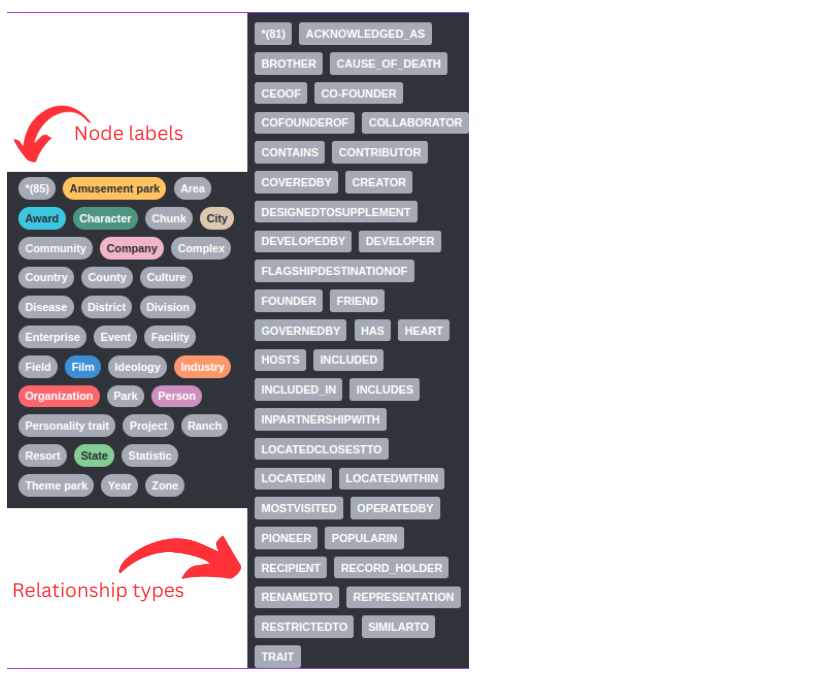

Since the graph schema is not provided, the LLM decides on the fly what types of node labels and relationship types it will use. For example, we can observe that there are Company and Organization node labels. Those two things are probably semantically similar or identical, so we would want to have only a single node label representing the two. This problem is more obvious with relationship types. 

For example, we have CO-FOUNDER and COFOUNDEROF relationships as well as DEVELOPER and DEVELOPEDBY. For any more serious project, you should define the node labels and relationship types the LLM should extract. Luckily, we have added the option to limit the types in the prompt by passing additional parameters.

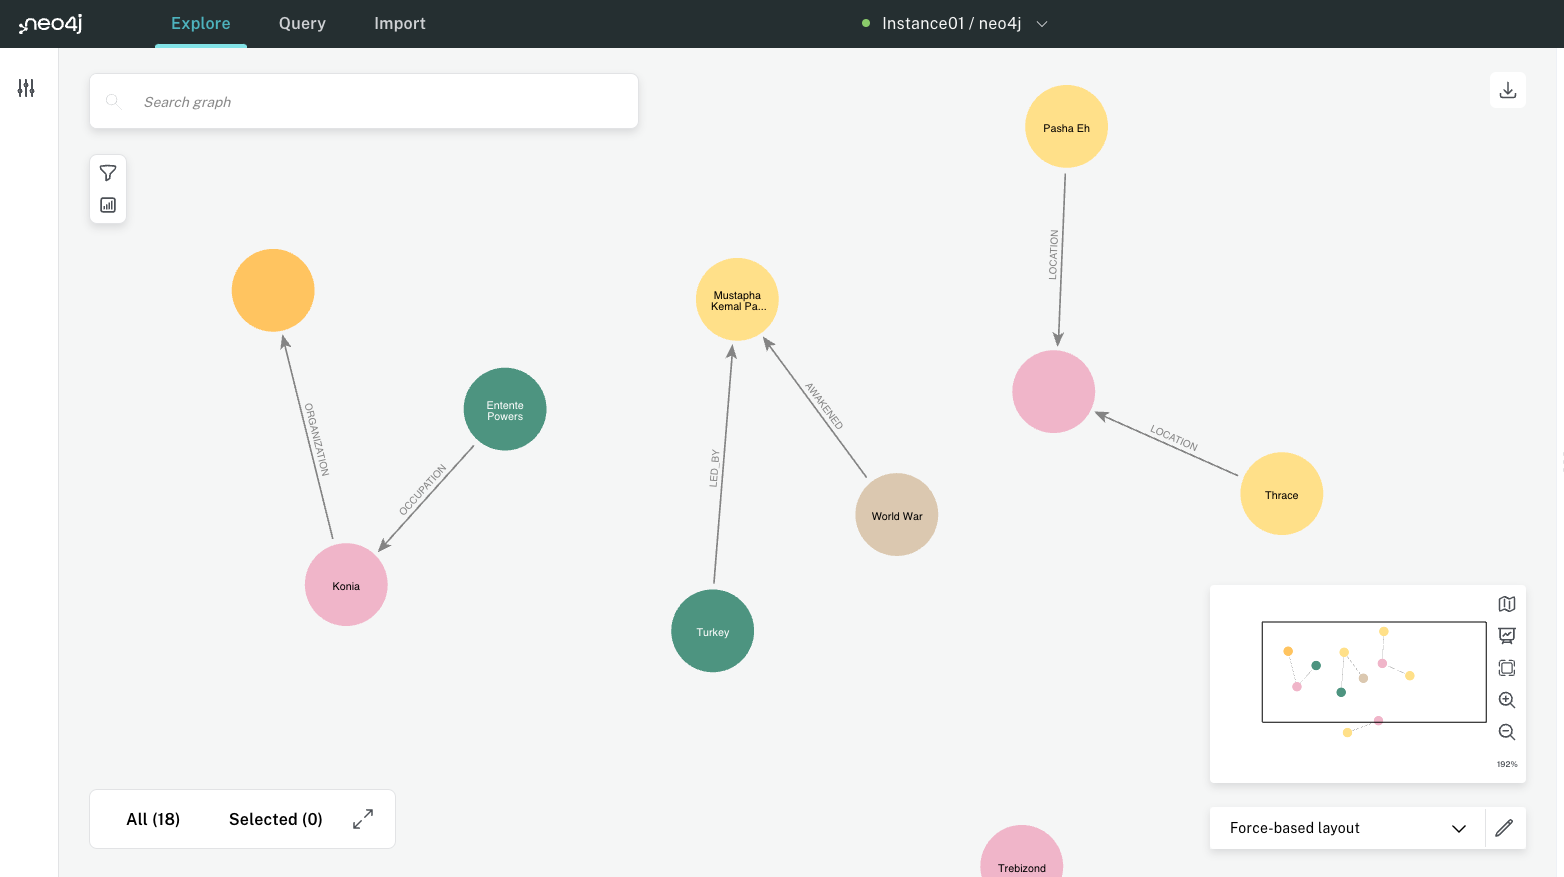

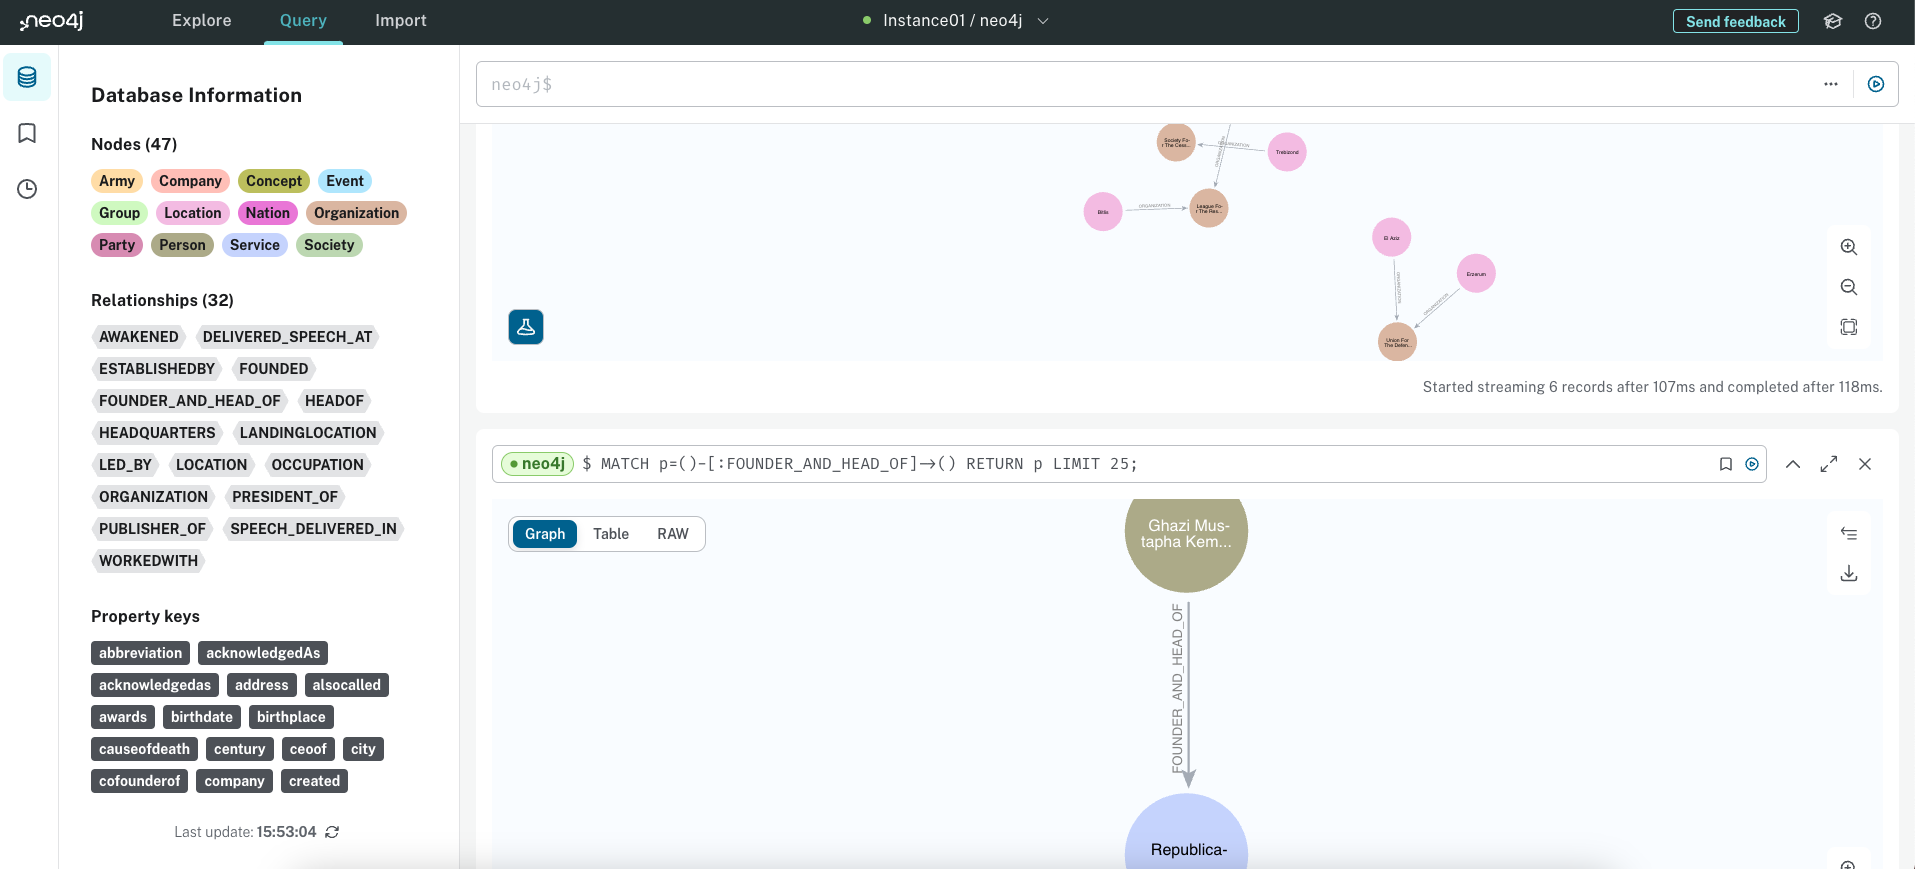

# The whole script for the txt book format

In [ ]:
from typing import List, Optional
from tqdm import tqdm

class Document:
    def __init__(self, content: str):
        self.page_content = content

    def to_dict(self):
        return {
            "page_content": self.page_content
        }

def extract_and_store_graph(
    document: Document,
    nodes: Optional[List[str]] = None,
    rels: Optional[List[str]] = None) -> None:
    # Extract graph data using OpenAI functions
    extract_chain = get_extraction_chain(nodes, rels)
    data = extract_chain.run(document.page_content)

    # Construct a graph document
    graph_document = GraphDocument(
        nodes = [map_to_base_node(node) for node in data.nodes],
        relationships = [map_to_base_relationship(rel) for rel in data.rels],
        source = document.to_dict()  # Convert to dictionary
    )

    # Store information into a graph
    graph.add_graph_documents([graph_document])

from langchain.text_splitter import TokenTextSplitter

# Define the path to your text file
file_path = "/Users/kemalgunay/Desktop/VERI_BILIMI/OpenAI_Graph/nutuk_english.txt"

# Read the content of the file into a string
with open(file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

# Create a TokenTextSplitter instance
text_splitter = TokenTextSplitter(chunk_size=2048, chunk_overlap=24)

# Use the split_text method to split the raw_text into chunks
texts = text_splitter.split_text(raw_text)

# Convert the chunks of text into Document objects
documents = [Document(content=text) for text in texts[:3]]

# Specify which node labels should be extracted by the LLM
allowed_nodes = ["Person", "Company", "Location", "Event", "Nation", "Service", "Award"]

for i, d in tqdm(enumerate(documents), total=len(documents)):
    extract_and_store_graph(d, allowed_nodes)
